<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/ADI/20210126_GAN_Uniform_to_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generative Adversarial Network (GAN)

Código base:
https://github.com/eriklindernoren/Keras-GAN



In [1]:
 ##Carregar bibliotecas
from keras.layers import Input, Dense, Reshape, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
# Seed para reprodução de resultados
seed = 10
random.seed(seed)
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

In [2]:
input_shape = (500,)
latent_dim = 100 # limitar o gerador

In [3]:
#gerar dados de entrada com distribuição uniforme
import pandas as pd
X = pd.DataFrame(np.random.uniform(0,1,size=(10000, latent_dim)))
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.771321,0.020752,0.633648,0.748804,0.498507,0.224797,0.198063,0.760531,0.169111,0.088340,0.685360,0.953393,0.003948,0.512192,0.812621,0.612526,0.721755,0.291876,0.917774,0.714576,0.542544,0.142170,0.373341,0.674134,0.441833,0.434014,0.617767,0.513138,0.650397,0.601039,0.805223,0.521647,0.908649,0.319236,0.090459,0.300700,0.113984,0.828681,0.046896,0.626287,...,0.597372,0.902832,0.534558,0.590201,0.039282,0.357182,0.079613,0.305460,0.330719,0.773830,0.039959,0.429492,0.314927,0.636491,0.346347,0.043097,0.879915,0.763241,0.878097,0.417509,0.605578,0.513467,0.597837,0.262216,0.300871,0.025400,0.303063,0.242076,0.557578,0.565507,0.475132,0.292798,0.064251,0.978819,0.339708,0.495049,0.977081,0.440774,0.318273,0.519797
1,0.578136,0.853934,0.068097,0.464531,0.781949,0.718603,0.586022,0.037094,0.350656,0.563191,0.299730,0.512334,0.673467,0.159194,0.050478,0.337816,0.108064,0.178903,0.885827,0.365365,0.218769,0.752496,0.106880,0.744603,0.469785,0.598256,0.147620,0.184035,0.645072,0.048628,0.248613,0.542409,0.226773,0.381412,0.922233,0.925357,0.566750,0.533471,0.014860,0.977899,...,0.295904,0.037558,0.030685,0.453105,0.744864,0.557295,0.385114,0.168073,0.838261,0.599052,0.782715,0.848509,0.603163,0.781061,0.615737,0.021165,0.750465,0.176042,0.458514,0.513123,0.484021,0.844386,0.174814,0.014635,0.848764,0.742675,0.456698,0.416898,0.116730,0.338679,0.094659,0.715831,0.077085,0.205950,0.573776,0.293832,0.655727,0.803568,0.351214,0.093440
2,0.813316,0.784867,0.393419,0.864479,0.384031,0.257303,0.829402,0.736383,0.507601,0.644327,0.213187,0.895709,0.965946,0.317002,0.865553,0.310284,0.025264,0.049195,0.184627,0.069033,0.257475,0.913582,0.457850,0.130212,0.809892,0.403470,0.024433,0.856831,0.274295,0.709106,0.355772,0.794309,0.844619,0.538148,0.559087,0.122510,0.377642,0.428747,0.511209,0.891763,...,0.263403,0.122336,0.458724,0.974812,0.680574,0.193254,0.046739,0.952644,0.858649,0.827903,0.963901,0.598936,0.930916,0.146769,0.113960,0.372029,0.766560,0.321142,0.638035,0.009221,0.543465,0.337755,0.898024,0.940707,0.384122,0.396118,0.897280,0.058822,0.405379,0.130176,0.086969,0.783964,0.304573,0.584056,0.878466,0.880792,0.600954,0.645228,0.056628,0.297484
3,0.691775,0.189029,0.803008,0.514764,0.757286,0.177789,0.082620,0.482072,0.528854,0.696308,0.204762,0.671372,0.793269,0.041738,0.963358,0.975393,0.550661,0.064907,0.345237,0.020430,0.800852,0.207927,0.143253,0.699894,0.057950,0.256608,0.510332,0.995259,0.146516,0.449515,0.601440,0.097272,0.288735,0.720800,0.550806,0.838577,0.580331,0.184572,0.615502,0.886955,...,0.087493,0.116879,0.771071,0.732795,0.087128,0.357463,0.773212,0.131472,0.537832,0.754724,0.272526,0.566517,0.476685,0.556621,0.440737,0.693737,0.718237,0.756382,0.037322,0.678835,0.477221,0.100171,0.614196,0.837915,0.733894,0.321566,0.067855,0.037330,0.559125,0.160853,0.267888,0.235712,0.019347,0.151686,0.033903,0.981835,0.360485,0.825465,0.412237,0.253179
4,0.236711,0.773116,0.671257,0.706331,0.853155,0.522050,0.442770,0.553748,0.651995,0.788554,0.892269,0.309105,0.135610,0.750927,0.526833,0.784739,0.429926,0.838847,0.537354,0.250424,0.058894,0.091949,0.174200,0.439254,0.810934,0.910402,0.576091,0.291154,0.651786,0.637921,0.503575,0.965553,0.806691,0.928519,0.613935,0.982004,0.714988,0.008659,0.288146,0.841399,...,0.279090,0.120680,0.480688,0.932302,0.914927,0.243875,0.394858,0.970240,0.275620,0.937849,0.769012,0.884719,0.871005,0.146471,0.789189,0.909222,0.838171,0.712031,0.307379,0.353785,0.236353,0.089812,0.194478,0.615808,0.932084,0.691084,0.562847,0.263756,0.527147,0.804383,0.295076,0.183339,0.019732,0.743321,0.038293,0.433680,0.832085,0.013459,0.509335,0.479549


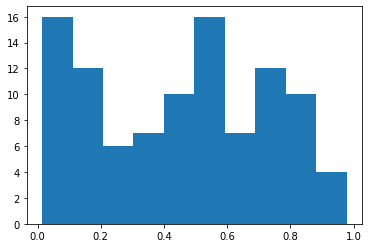

In [4]:
#distribuicao para amostra
linha1 = X.iloc[1,:]
histogram_i = plt.hist(linha1)

###Exercício 1: Gerar dados com distbuição normal. Salvar em uma variável chamada 'y'. Plotar o histograma. Imprimir a média e o desvio de uma amostra qualquer.

In [ ]:
# Criar o Gerador
generator = Sequential()

generator.add(Dense(256, input_dim=latent_dim))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(np.prod(input_shape), activation='linear'))
generator.add(Reshape(input_shape))
generator.summary()

noise = Input(shape=(latent_dim,))
distribution = generator(noise)
generator = Model(noise, distribution)

# Compilar o gerador
optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
# Criar o Discriminador
discriminator = Sequential()

discriminator.add(Dense(512, input_shape=input_shape))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

distribution = Input(shape=input_shape)
validity = discriminator(distribution)
discriminator = Model(distribution, validity)

# Compilar o discriminador
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# O gerador recebe um ruído como entrada e gera a amostra com a distribuição aprendida
input = Input(shape=(latent_dim,))
gen_data = generator(input)
validity = discriminator(gen_data)

# Para o modelo combinado, somente treinaremos o gerador
discriminator.trainable = False

# Modelo combinado: stacked generator and discriminator
# Treina o gerador para enganar o discriminador
combined = Model(input, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Mostrar a estrutura do modelo criado
config = combined.get_config()
model = Model.from_config(config)
model.summary()

In [ ]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.uniform(0, 1, (r * c, latent_dim))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].hist(gen_imgs[cnt, :])
          axs[i,j].axis('off')
          # axs[i,j].set_title(epoch)
          fig.suptitle(epoch)
          cnt += 1
  plt.subplots(r, c)
  plt.close()

In [ ]:
batch_size=32
epochs=1200
sample_interval=200

# history
d_loss_history = []
d_acc_history = []
d_acc_real_history = []
d_acc_fake_history = []
g_loss_history = []
g_acc_history = []

# Vetores com 0s e 1s indicando, respectivamente, amostras fakes e reais
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

# ---------------------
#  Treina o Discriminador
# ---------------------
# Seleciona um batch aleatório de dados
  idx = np.random.randint(0, len(X[1]), batch_size)
  imgs = y.iloc[idx,:]
  noise = X.iloc[idx,:]

  # Gera um batch de novos dados
  gen_imgs = generator.predict(noise)

  # Treina o discriminador
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  d_loss_history.append(d_loss[0])
  d_acc_history.append(d_loss[1])
  d_acc_real_history.append(d_loss_real[1])
  d_acc_fake_history.append(d_loss_fake[1])

  # ---------------------
  #  Treina o Gerador
  # ---------------------

  # Treina o gerador para que faça o discriminador classificar os dados criados como reais
  g_loss, g_acc = combined.train_on_batch(noise, valid)

  g_loss_history.append(g_loss)
  g_acc_history.append(g_acc)
  
  # Progresso
  print ("%d [D loss: %f, accDreal.: %.2f%%, accDfake.: %.2f%%] [G loss: %f, accG.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss, 100*g_acc))

  # Gerar imagens ao longo do treinamento
  if epoch % sample_interval == 0:
    sample_images(epoch)


In [ ]:
# Gráfico da evolução do erro e da acurácia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(d_loss_history, label='discriminador')
ax1.plot(g_loss_history, label='gerador')
ax1.set_title('Loss')
ax1.set_xlabel('época')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(d_acc_history, label='discriminador')
ax2.plot(g_acc_history, label='gerador')
ax2.set_title('Acurácia')
ax2.set_xlabel('época')
ax2.set_ylabel('acurácia')
ax2.legend()
plt.show()

In [ ]:
plt.plot(d_acc_real_history, label='real')
plt.plot(d_acc_fake_history, label='fake')
plt.title('Acurácia Discriminador')
plt.xlabel('época')
plt.ylabel('acurácia')
plt.legend()
plt.show()

###Exercício 2: Criar uma amostra para teste. Visualizar a base (função head())

###Exercício 3: visualizar algumas características da base através da função describe()

In [ ]:
#por coluna. Aproximadamente a mesma distribuiçao que criamos por linha


###Exercicio 4: plotar o histograma da base de teste (ruído) gerada

In [ ]:
#distribuicao: primeira linha

###Exercício 5: Utilizar a GAN treinada para gerar dados com a distribuição desejada

###Exercício 6: plotar o histograma da distribuição dos dados gerados pela GAN